<a href="https://colab.research.google.com/github/SkipperNZ/Advanced-ML/blob/main/Advanced_ML_HW1_Lomakin_N_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [439]:
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression, Ridge


# 1 часть

Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).

In [440]:
!wget -q https://covid.ourworldindata.org/data/owid-covid-data.csv

In [441]:
# Константы
START_IN_RUS = datetime(2020, 3, 3)
TRAIN_DATE_BORDER = START_IN_RUS + timedelta(days=50)
print('TRAIN_DATE_BORDER: ',TRAIN_DATE_BORDER)

TRAIN_DATE_BORDER:  2020-04-22 00:00:00


In [442]:
df = pd.read_csv("/content/owid-covid-data.csv")
print("Форма всего датасета", df.shape)

#интересующие нас колонки 
intresting_columns = ['location', 'date', 'total_cases', 'new_cases']
df = df[intresting_columns]
print("Форма усечённого датасета", df.shape)

# форматнём даты
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

# Локальный датасет
df_rus = df.loc[df['location'] == "Russia"]
print("Форма ru датасета", df_rus.shape)

# Локальный датасет с начала роста
df_rus =  df_rus.loc[df['date'] >= START_IN_RUS]
print("Форма ru датасета c начала роста", df_rus.shape)

Форма всего датасета (162372, 67)
Форма усечённого датасета (162372, 4)
Форма ru датасета (748, 4)
Форма ru датасета c начала роста (716, 4)


In [443]:
# для упрощения заменим все нули в new_cases на единицы
print(df_rus.loc[df_rus["new_cases"] == 0].size)
df_rus.loc[df_rus["new_cases"] == 0, "new_cases"] = 1
print(df_rus.loc[df_rus["new_cases"] == 0].size)

20
0


In [444]:
# добавим колонку с номером дня начиная с 3тьего марта
df_rus["day_number"] = (df_rus["date"] - START_IN_RUS).dt.days

In [445]:
df_rus_train = df_rus.loc[df['date'] < TRAIN_DATE_BORDER]
df_rus_test = df_rus.loc[df['date'] >= TRAIN_DATE_BORDER]
print('df_rus_train', df_rus_train.shape)
print('df_rus_test', df_rus_test.shape)

df_rus_train (50, 5)
df_rus_test (666, 5)


In [446]:
df_rus_train.head()

,location,date,total_cases,new_cases,day_number
120849,Russia,2020-03-03,3.0,1.0,0
120850,Russia,2020-03-04,3.0,1.0,1
120851,Russia,2020-03-05,4.0,1.0,2
120852,Russia,2020-03-06,13.0,9.0,3
120853,Russia,2020-03-07,13.0,1.0,4


# 2 часть

Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.

In [447]:
FIGSIZE = ((28, 9))
FONTSIZE_ON_PLT = 20

Графики для всего датасета

Text(0, 0.5, 'num of cases')

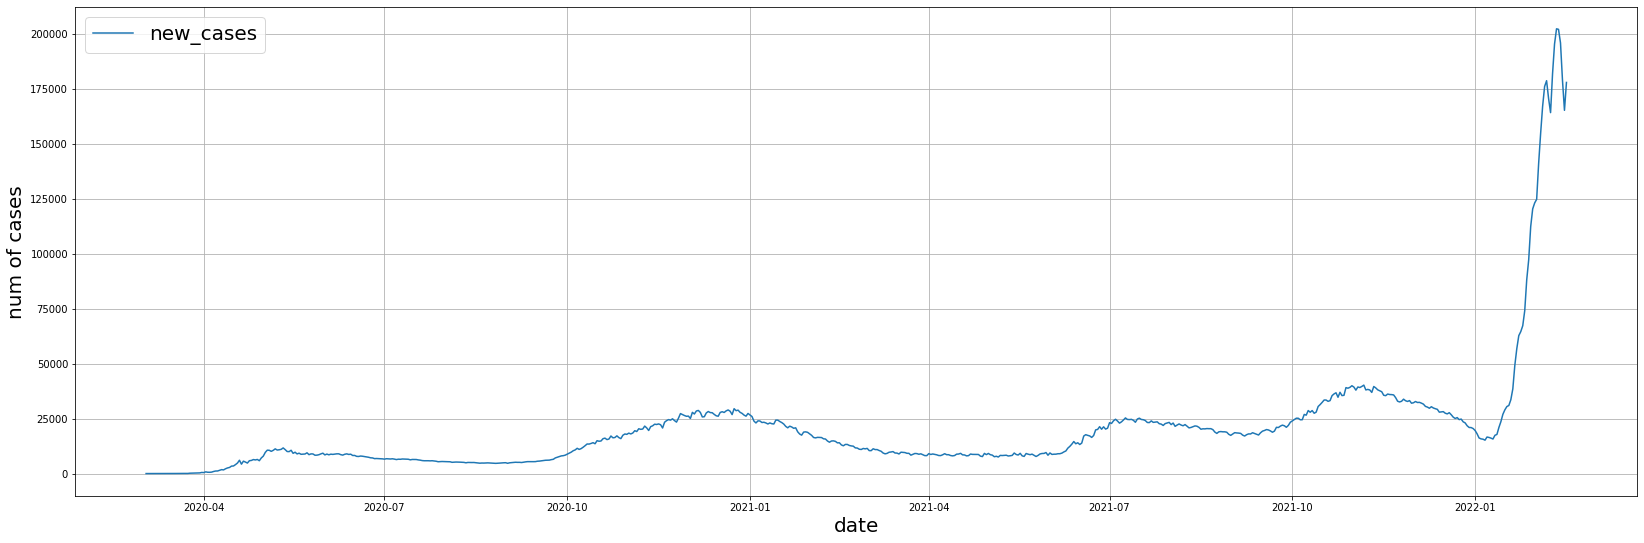

In [448]:
plt.figure(figsize=FIGSIZE)
plt.plot(df_rus['date'], df_rus['new_cases'], label='new_cases')
plt.legend(fontsize=FONTSIZE_ON_PLT)
plt.grid(True)
plt.xlabel('date', fontsize=FONTSIZE_ON_PLT)
plt.ylabel('num of cases', fontsize=FONTSIZE_ON_PLT)

Text(0, 0.5, 'num of cases')

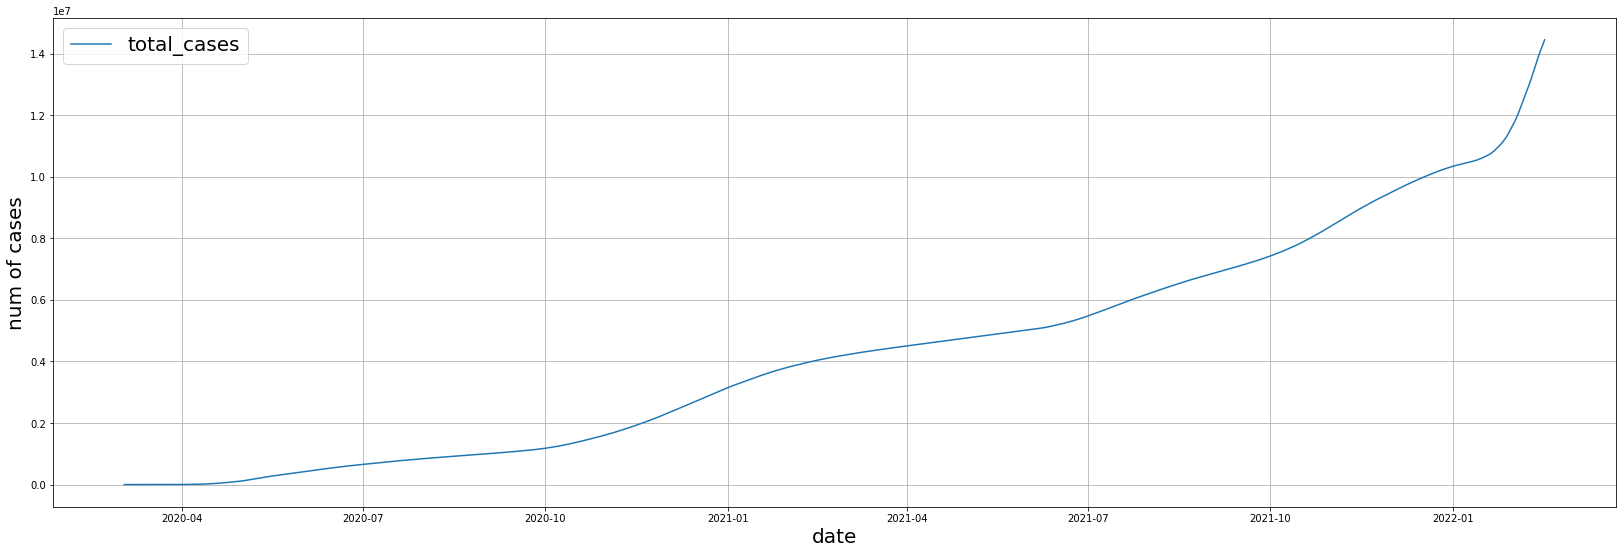

In [449]:
plt.figure(figsize=FIGSIZE)
plt.plot(df_rus['date'], df_rus['total_cases'], label='total_cases')
plt.legend(fontsize=FONTSIZE_ON_PLT)
plt.grid(True)
plt.xlabel('date', fontsize=FONTSIZE_ON_PLT)
plt.ylabel('num of cases', fontsize=FONTSIZE_ON_PLT)

Графики для первых 50 дней

Text(0, 0.5, 'num of cases')

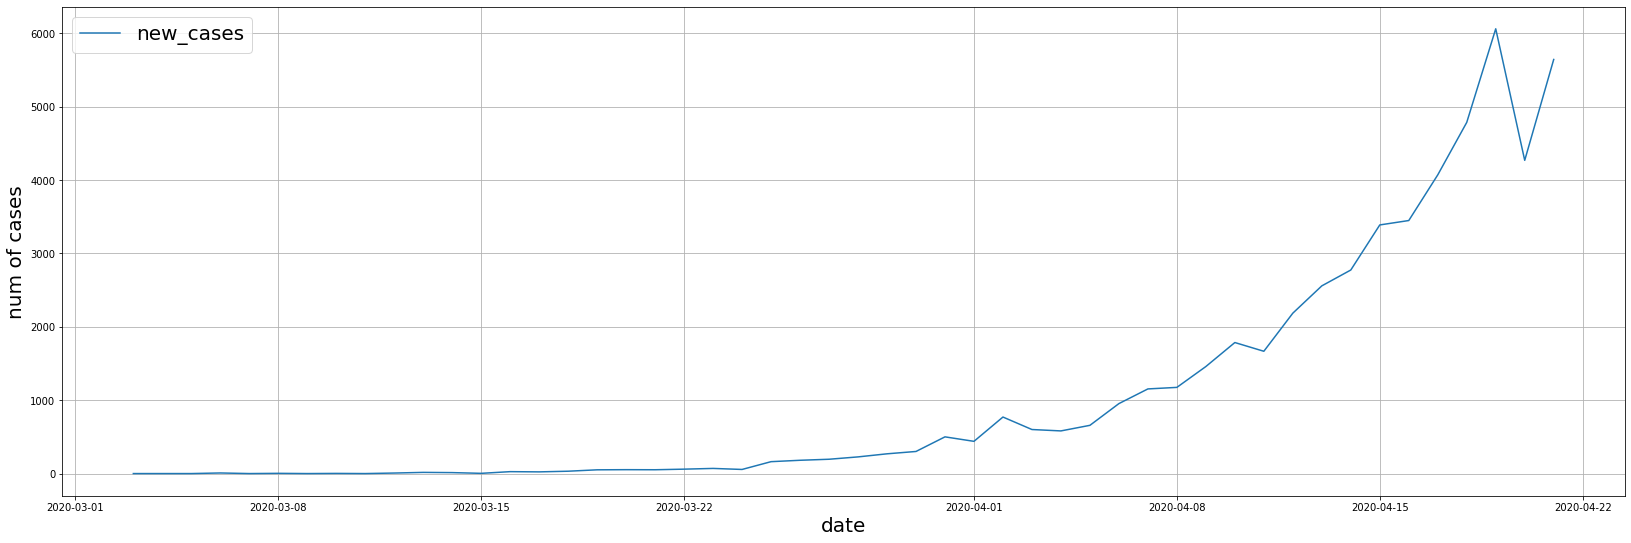

In [450]:
plt.figure(figsize=FIGSIZE)
plt.plot(df_rus_train['date'], df_rus_train['new_cases'], label='new_cases')
plt.legend(fontsize=FONTSIZE_ON_PLT)
plt.grid(True)
plt.xlabel('date', fontsize=FONTSIZE_ON_PLT)
plt.ylabel('num of cases', fontsize=FONTSIZE_ON_PLT)

Text(0, 0.5, 'num of cases')

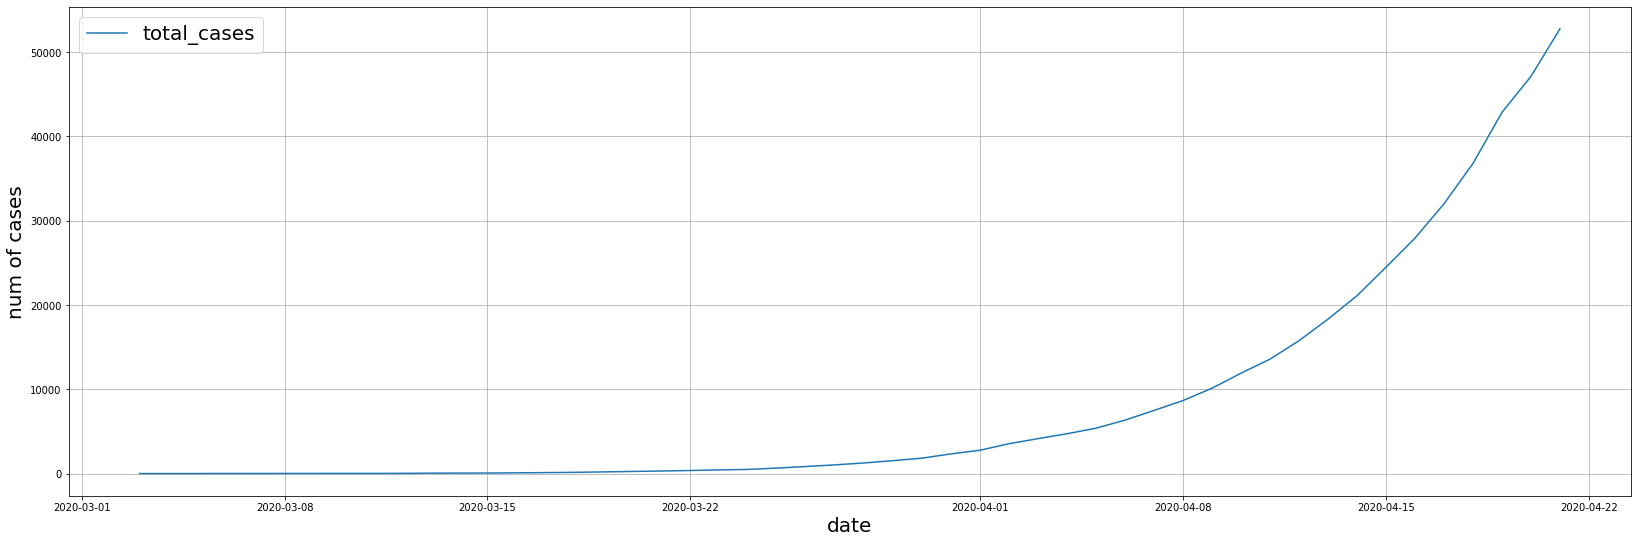

In [451]:
plt.figure(figsize=FIGSIZE)
plt.plot(df_rus_train['date'], df_rus_train['total_cases'], label='total_cases')
plt.legend(fontsize=FONTSIZE_ON_PLT)
plt.grid(True)
plt.xlabel('date', fontsize=FONTSIZE_ON_PLT)
plt.ylabel('num of cases', fontsize=FONTSIZE_ON_PLT)

## 2.a

Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

Итак зависимость имеет вид:
$$\large
y \sim e^{b + kx}
$$
Прологарифмировав это получаем:
$$\large
\ln y \sim b + kx
$$

In [452]:
from sklearn.linear_model import LinearRegression

reg_total_cases = LinearRegression()
reg_total_cases.fit(df_rus_train['day_number'].values.reshape(-1, 1), np.log(df_rus_train['total_cases']))


LinearRegression()

Text(0, 0.5, 'num of cases')

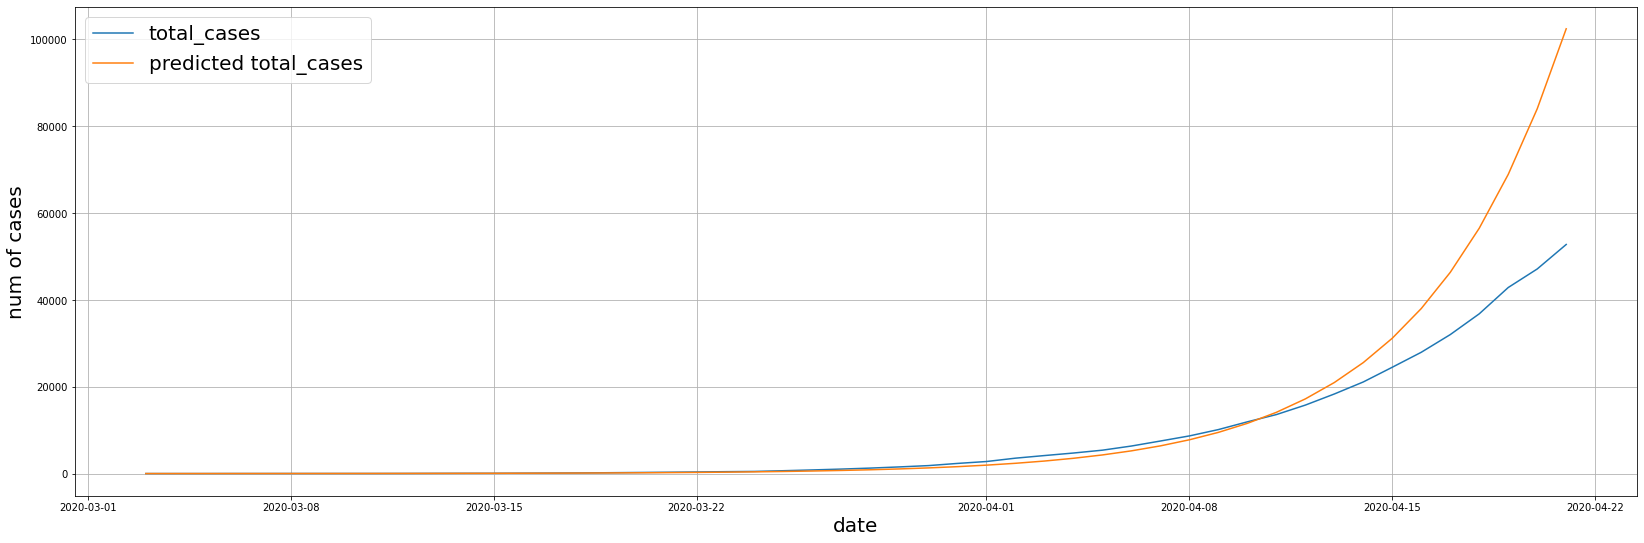

In [453]:
predict = reg_total_cases.predict(df_rus_train['day_number'].values.reshape(-1, 1))

plt.figure(figsize=FIGSIZE)
plt.plot(df_rus_train['date'], df_rus_train['total_cases'], label='total_cases')
plt.plot(df_rus_train['date'], np.exp(predict), label='predicted total_cases')
plt.legend(fontsize=FONTSIZE_ON_PLT)
plt.grid(True)
plt.xlabel('date', fontsize=FONTSIZE_ON_PLT)
plt.ylabel('num of cases', fontsize=FONTSIZE_ON_PLT)

## 2.b

Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

Дисперсию расчитываю так:
$$\large
\sigma^{2} = \frac{1}{N} \sum\limits_{i=1}^{N} (y_{n}-\bar{w}^{T}ϕ(\bar{x}_{n}))^{2}
$$



In [454]:
sig_square = np.mean((np.log(df_rus_train['total_cases']) - predict)**2 )
sig_square

0.12183046154391233

Теперь найдём апостериорное распределение параметров

Итак задача постчитать 
$$\large 
p(w|t) \propto p(t|X,w,\sigma^{2})p(w) =
\textit{N}(w|\mu_{0},\Sigma_{0})
\prod\limits_{n=1}^{N}\textit{N}(t_{n}|w^{T}ϕ(x_{n}),\sigma^{2})
$$

Тут происходит черная магия и на выходе получается:
$$\large
p(w|t) = \textit{N}(w|\mu_{N}, \Sigma_{N}) \\
$$

Где:

$$\large
\mu_{N} = \Sigma_{N} \left ( \Sigma_{0}^{-1}\mu_{0} + \frac{1}{\sigma^{2}} \Phi^{T}t \right )
$$

$$\large
\Sigma_{N} = \left ( \Sigma_{0}^{-1} + \frac{1}{\sigma^{2}} \Phi^{T}\Phi \right ) ^{-1}
$$


In [457]:
def update_params(mu_zero, sigma_zero, x, y, dispersion: float):

  sigma_n = np.linalg.inv(np.linalg.inv(sigma_zero) + (1/dispersion)* np.dot(x.T, x))

  mu_n = sigma_n.dot(np.linalg.inv(sigma_zero).dot(mu_zero) + (1/dispersion) * np.dot(x.T, y))

  
  return sigma_n, mu_n


In [458]:
x = np.column_stack([np.ones(df_rus_train.shape[0]), df_rus_train["day_number"]])
sigma, mu = update_params(np.zeros(2),
                          1000*np.eye(2),
                          x,
                          np.log(df_rus_train['total_cases']).values,
                          sig_square)

In [459]:
sigma

array([[ 9.45968745e-03, -2.86657194e-04],
       [-2.86657194e-04,  1.17003222e-05]])

In [460]:
mu

array([1.82071998, 0.19829143])

## 2.c

Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

In [461]:
num_of_samples = 800
w_samples = np.random.multivariate_normal(mu, sigma, num_of_samples)
y_samples = [np.exp(w[0] + df_rus_train['day_number'].values * w[1])   for w in w_samples]

Text(0, 0.5, 'num of cases')

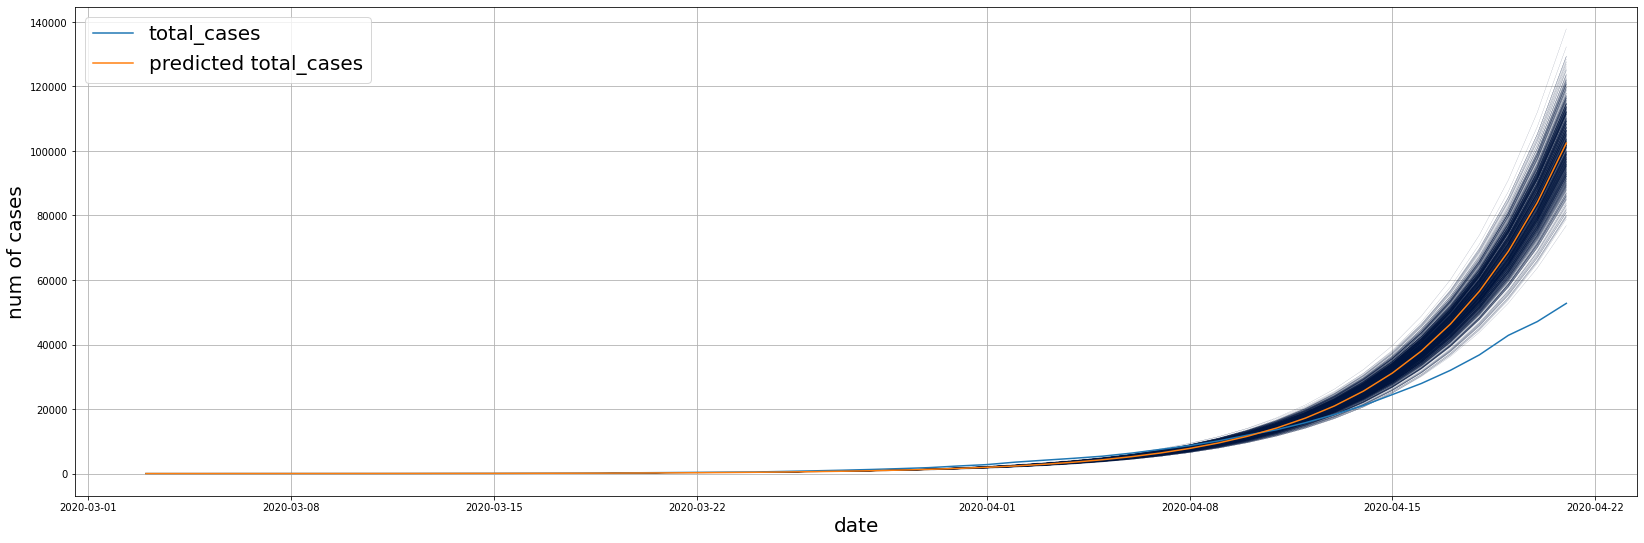

In [462]:
plt.figure(figsize=FIGSIZE)

for n in range(num_of_samples):
  plt.plot(df_rus_train['date'], y_samples[n], color="#01153E", linewidth=.1)

plt.plot(df_rus_train['date'], df_rus_train['total_cases'], label='total_cases')
plt.plot(df_rus_train['date'], np.exp(predict), label='predicted total_cases')

plt.legend(fontsize=FONTSIZE_ON_PLT)
plt.grid(True)
plt.xlabel('date', fontsize=FONTSIZE_ON_PLT)
plt.ylabel('num of cases', fontsize=FONTSIZE_ON_PLT)

Теперь построим гистаграммы распределений на первые числа мая, июня и сентября.



In [463]:
MAY_FIRST = (datetime(2020, 5, 1) - START_IN_RUS).days
JUNE_FIRST = (datetime(2020, 6, 1) - START_IN_RUS).days
SEPTEMBER_FIRST = (datetime(2020, 9, 1) - START_IN_RUS).days
print("Дней от старта до 1 мая: ", MAY_FIRST)
print("Дней от старта до 1 июня: ", JUNE_FIRST)
print("Дней от старта до 1 сентября: ", SEPTEMBER_FIRST)

Дней от старта до 1 мая:  59
Дней от старта до 1 июня:  90
Дней от старта до 1 сентября:  182


In [464]:
x_day_matrix = np.column_stack([np.ones(3), [MAY_FIRST, JUNE_FIRST, SEPTEMBER_FIRST]])
x_day_matrix

array([[  1.,  59.],
       [  1.,  90.],
       [  1., 182.]])

In [465]:
preds = np.exp(w_samples.dot(x_day_matrix.T))

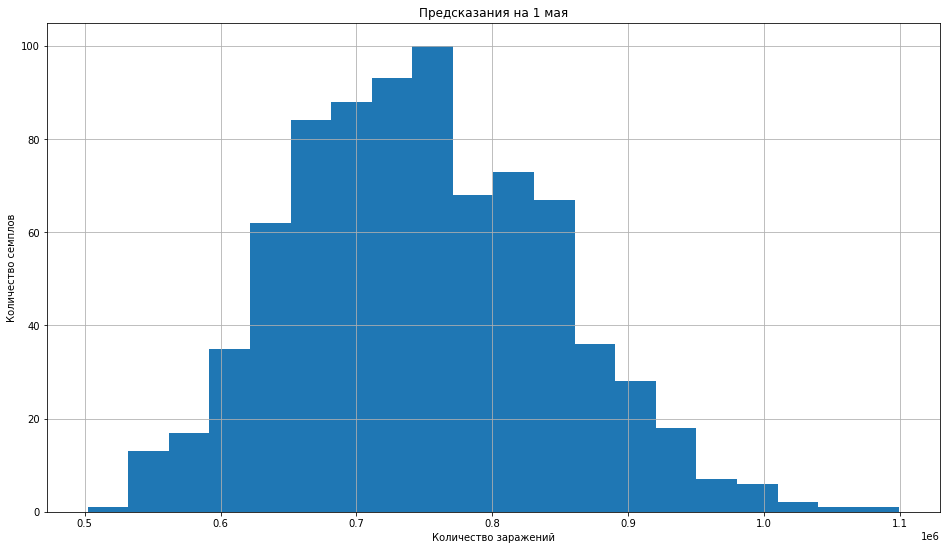

In [466]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.hist(preds[:,0],  bins=20)

plt.xlabel("Количество заражений")
plt.ylabel("Количество семплов")
plt.title("Предсказания на 1 мая");


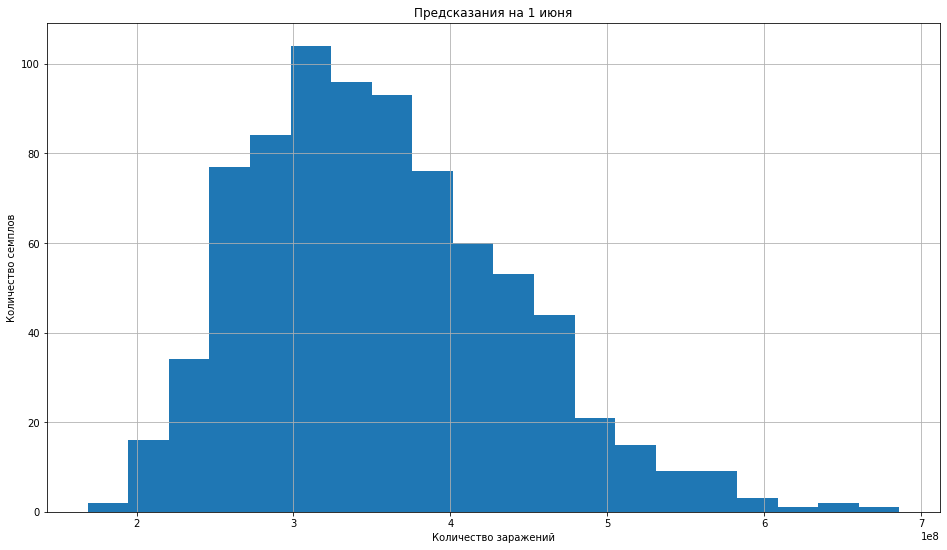

In [467]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.hist(preds[:,1],  bins=20)

plt.xlabel("Количество заражений")
plt.ylabel("Количество семплов")
plt.title("Предсказания на 1 июня");

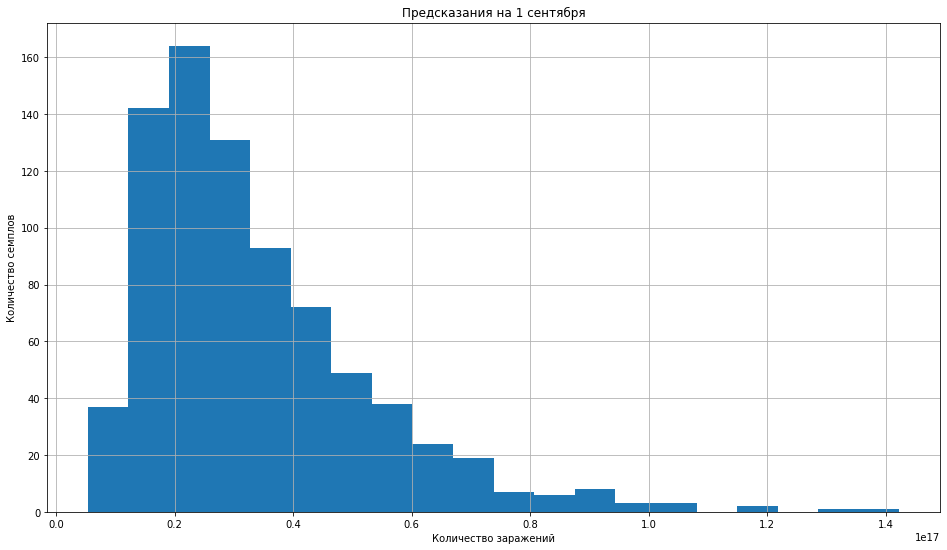

In [468]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.hist(preds[:,2],  bins=20)

plt.xlabel("Количество заражений")
plt.ylabel("Количество семплов")
plt.title("Предсказания на 1 сентября");

In [469]:
 ans = np.exp(reg_total_cases.predict(np.array([MAY_FIRST,JUNE_FIRST,SEPTEMBER_FIRST]).reshape(-1, 1)))
 print("Количество милионов заражений на 1 мая: ", ans[0] / 1_000_000)
 print("Количество милионов заражений на 1 июня: ", ans[1] / 1_000_000)
 print("Количество милионов заражений на 1 сентября: ", ans[2] / 1_000_000)

Количество милионов заражений на 1 мая:  0.7440778731884614
Количество милионов заражений на 1 июня:  347.7238746096563
Количество милионов заражений на 1 сентября:  29104907396.230515


Судя по этой модели - всё очень плохо. Похоже что она не очень хорошо работает что бы описать данные хоть немногим больше месяца.

# 3 часть

Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана:

$$\large
\Phi(x) = \frac{1}{\sqrt{2\pi}}\int\limits_{-\infty}^{x} e^{-t^{2}/2}dt
$$

Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.


## 3.a

Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

Что бы избавится от интеграла, надо взять производную, производная по total_cases удивительно удобно равна new_cases.
От экспоненты традиционно можно избавится с помощью логарифма. 
Ну и возьмем квадратичную функцию t: $\large at^2+bt+c$
Тогда формула для регрессии будет иметь вид
$$\large
\ln y_{(new\_cases)} = ax^2+bx+c
$$


## 3.b

Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

In [470]:
reg_sigmoid = LinearRegression()

X = np.column_stack([df_rus_train['day_number'], df_rus_train['day_number'] ** 2])
y = np.log(df_rus_train['new_cases'].values)
reg_sigmoid.fit(X,y)

LinearRegression()

Text(0, 0.5, 'num of cases')

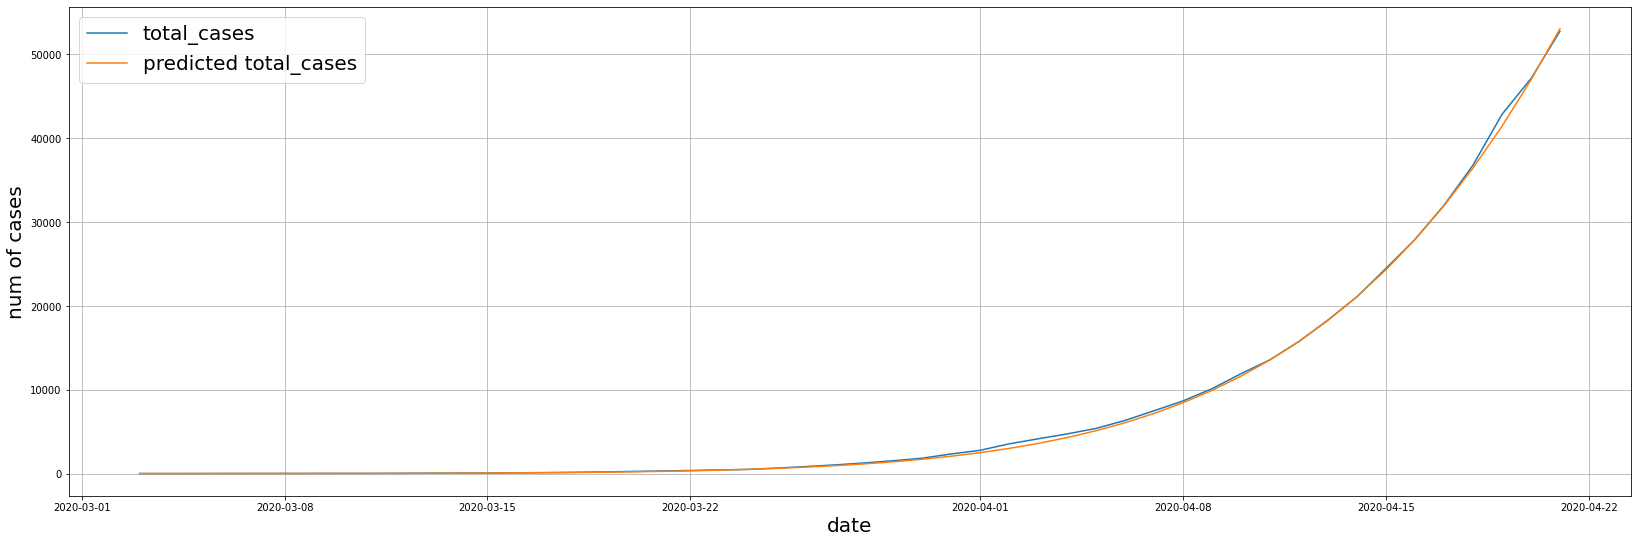

In [471]:
predict = reg_sigmoid.predict(X)

plt.figure(figsize=FIGSIZE)
plt.plot(df_rus_train['date'], df_rus_train['total_cases'], label='total_cases')
plt.plot(df_rus_train['date'], np.exp(predict).cumsum(), label='predicted total_cases')
plt.legend(fontsize=FONTSIZE_ON_PLT)
plt.grid(True)
plt.xlabel('date', fontsize=FONTSIZE_ON_PLT)
plt.ylabel('num of cases', fontsize=FONTSIZE_ON_PLT)

In [472]:
sig_square = np.mean((y - predict)**2) # y уже под логарифмами
sig_square

0.23928684127005564

In [473]:
X = np.column_stack([np.ones_like(df_rus_train["day_number"]), X])

In [474]:
  sigma, mu  = update_params(
    np.zeros(3),
    1000 * np.eye(3),
    X,
    y,
    sig_square
)

In [475]:
mu


array([-0.39657373,  0.27562146, -0.00182977])

In [476]:
sigma

array([[ 3.98001444e-02, -3.21562616e-03,  5.41351180e-05],
       [-3.21562616e-03,  3.54561191e-04, -6.76698532e-06],
       [ 5.41351180e-05, -6.76698532e-06,  1.38102366e-07]])

## 3.c

Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

In [477]:
num_of_samples = 800
w_samples = np.random.multivariate_normal(mu, sigma, num_of_samples)
y_samples = [np.exp(w[0] + df_rus_train['day_number'].values * w[1] + (df_rus_train['day_number'].values **2) * w[2])   for w in w_samples]

Text(0, 0.5, 'num of cases')

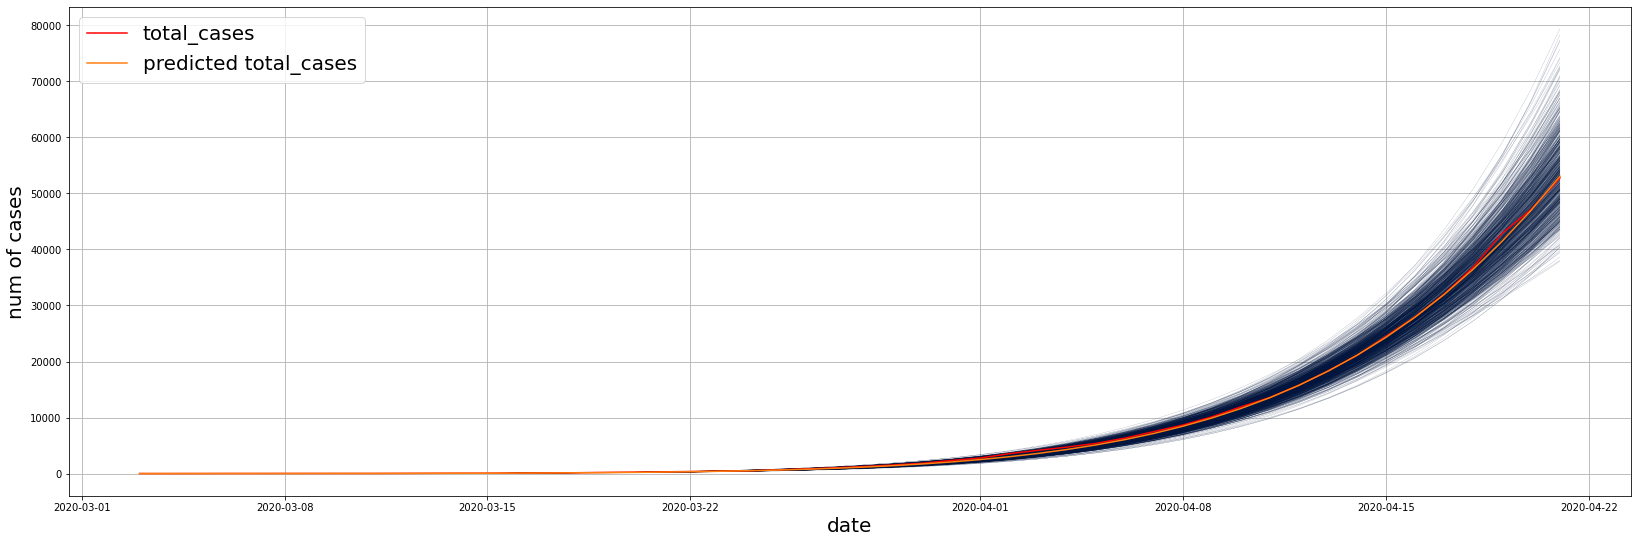

In [478]:
plt.figure(figsize=FIGSIZE)

for n in range(num_of_samples):
  #plt.plot(df_rus_train['date'], y_samples[n], color="0.2", linewidth=.1)
  plt.plot(df_rus_train['date'], np.exp(X.dot(w_samples[n])).cumsum(), color="#01153E", linewidth=0.1)

plt.plot(df_rus_train['date'], df_rus_train['total_cases'], label='total_cases', color='r')
plt.plot(df_rus_train['date'], np.exp(predict).cumsum(), label='predicted total_cases', color='#ff7f0e')

plt.legend(fontsize=FONTSIZE_ON_PLT)
plt.grid(True)
plt.xlabel('date', fontsize=FONTSIZE_ON_PLT)
plt.ylabel('num of cases', fontsize=FONTSIZE_ON_PLT)

Text(0, 0.5, 'num of cases')

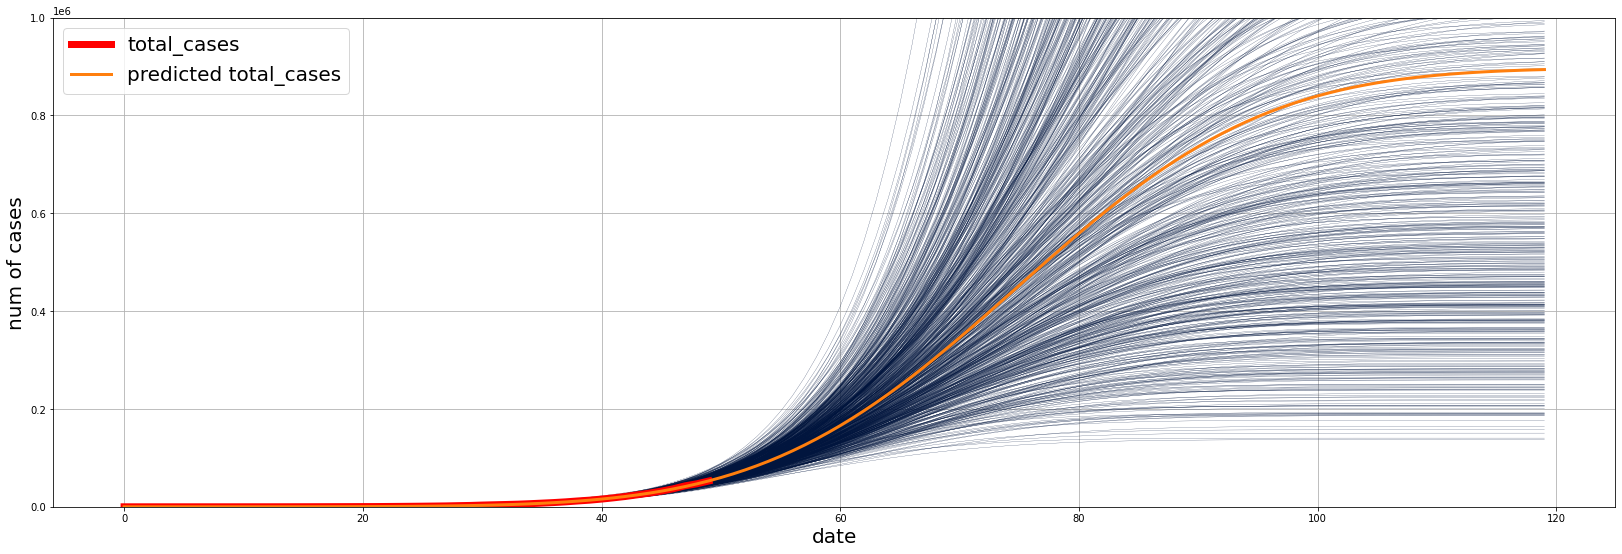

In [479]:
days_in_x = np.arange(120)
w2_samples = np.random.multivariate_normal(mu, sigma, num_of_samples)

x_for_predict = np.column_stack([days_in_x, days_in_x ** 2])
x_for_aprox = np.column_stack([np.ones(days_in_x.shape[0]), days_in_x, days_in_x ** 2])

predict2 = reg_sigmoid.predict(x_for_predict)

plt.figure(figsize=FIGSIZE)

for n in range(num_of_samples):
  plt.plot(days_in_x, np.exp(x_for_aprox.dot(w2_samples[n])).cumsum(), color="#01153E", linewidth=0.2)

plt.plot(np.arange(50), df_rus_train['total_cases'].values, label='total_cases', color="r", linewidth = 7)
plt.plot(days_in_x, np.exp(predict2).cumsum(), label='predicted total_cases', color="#ff7f0e", linewidth = 3)

plt.ylim(0, 1_000_000)
plt.legend(fontsize=FONTSIZE_ON_PLT)
plt.grid(True)
plt.xlabel('date', fontsize=FONTSIZE_ON_PLT)
plt.ylabel('num of cases', fontsize=FONTSIZE_ON_PLT)

In [480]:
days_in_x = np.arange(SEPTEMBER_FIRST + 1)
x_day_matrix_for_sigmoid = np.column_stack([np.ones(days_in_x.shape[0]), days_in_x, days_in_x ** 2])

preds = np.exp(w_samples.dot(x_day_matrix_for_sigmoid.T)).cumsum(1)

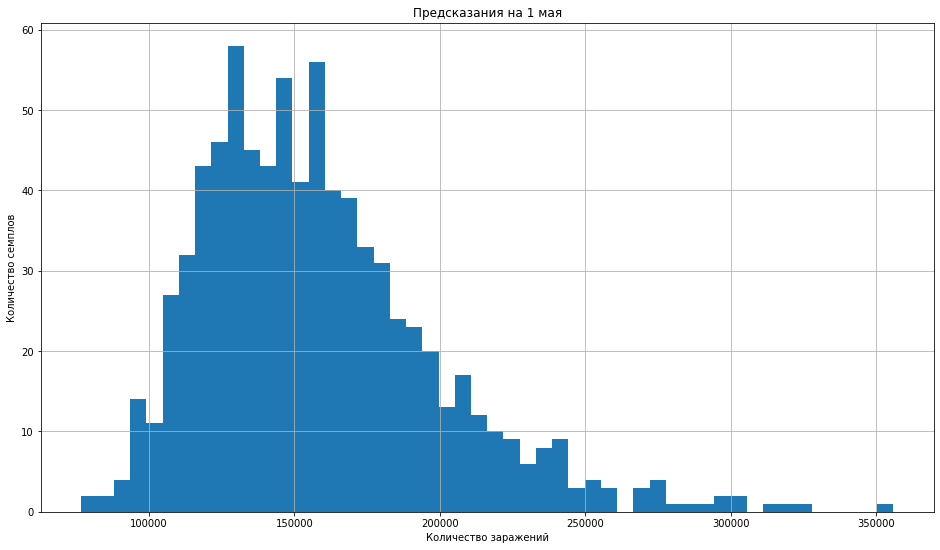

In [481]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.hist(preds[:, MAY_FIRST],  bins=50)

plt.xlabel("Количество заражений")
plt.ylabel("Количество семплов")
plt.title("Предсказания на 1 мая");

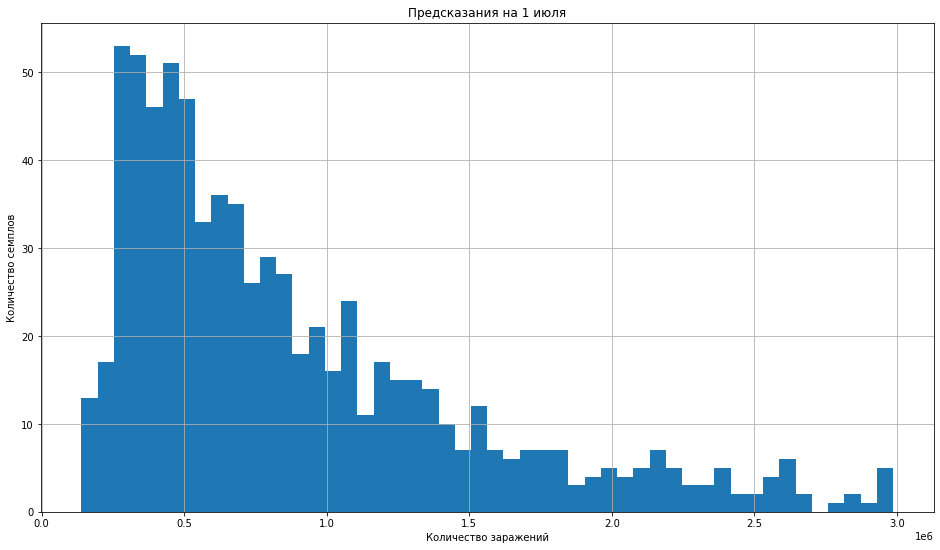

In [482]:
max_show_in_hist = 3_000_000

plt.figure(figsize=(16, 9))
plt.grid(True)
plt.hist(preds[:, JUNE_FIRST][preds[:, JUNE_FIRST ] < max_show_in_hist],  bins=50)

# plt.xlim(0, 5.0 * 1e6)
plt.xlabel("Количество заражений")
plt.ylabel("Количество семплов")
plt.title("Предсказания на 1 июля");

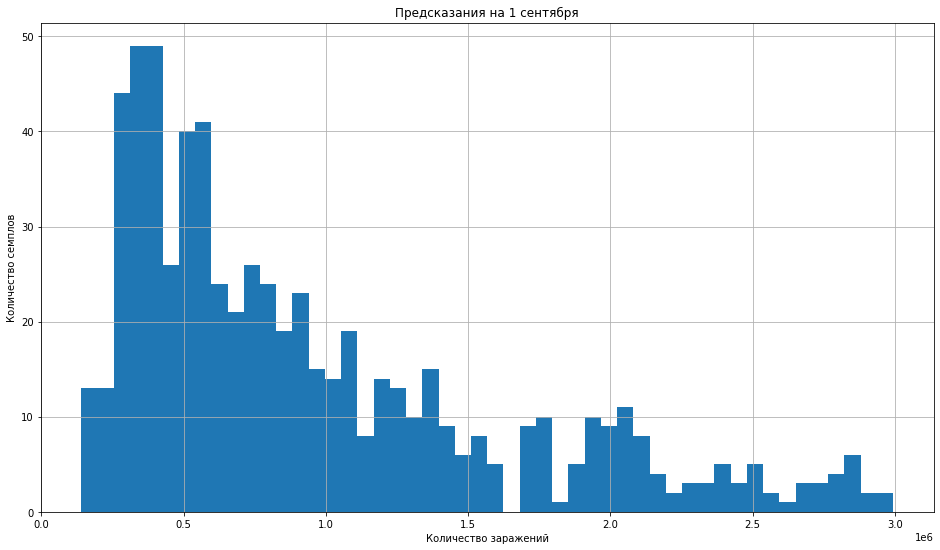

In [483]:
max_show_in_hist = 3_000_000

plt.figure(figsize=(16, 9))
plt.grid(True)
plt.hist(preds[:, SEPTEMBER_FIRST][preds[:, SEPTEMBER_FIRST ] < max_show_in_hist],  bins=50)
plt.xlabel("Количество заражений")
plt.ylabel("Количество семплов")
plt.title("Предсказания на 1 сентября");

Теперь рассмотрим сколько "всего" по нашей модели будет случаев короновируса в России (можно рассматривать дату - 1ого сентября, так как там уже сигмоида более менее выравнивается в константу). Похоже что это релевантно только на первую волну, и приближать этой моделью данные дальше бессмыслено, потому что эпидемия развивалась волнами, было много независимых факторов.

In [487]:
dff = df_rus['total_cases'].reset_index(drop=True)
first_september_pred_matrix = np.column_stack([days_in_x, days_in_x ** 2])
first_september_pred = np.exp(reg_sigmoid.predict(first_september_pred_matrix)).sum()

print(f'Оптимистичный прогноз: {int(np.quantile(preds[:, -1], 0.1)) / 1_000_000:.4f} млн человек')
print(f'Пессимистичный прогноз: {int(np.quantile(preds[:, -1], 0.9)) / 1_000_000:.4f} млн человек')
print(f'Число заражений по отчетам: { dff[SEPTEMBER_FIRST] / 1_000_000:.4f} млн человек')
print(f'Число заражений по модели: { first_september_pred / 1_000_000:.4f} млн человек')

Оптимистичный прогноз: 0.3228 млн человек
Пессимистичный прогноз: 5.4478 млн человек
Число заражений по отчетам: 0.9971 млн человек
Число заражений по модели: 0.8971 млн человек


Эта модель работает уже сильно лучше предыдущей. Тут уже прогноз на первое сентябра сопостовим с реальными данными. 

## Выводы

Итак "You Know, I Learned Something Today" ©

 * Экстраполяция - не очень хорошо работает, особенно если не правильно выбрать модель. На графике с кучей семплов хорошо видно как со временем растёт степень "неуверенности" модели. и видно что разброс от оптимистического до пессимистического варианта очень большой. 
 * Решение о вводе карантина, похоже всё таки не настолько сильно связано с динамикой заражений, а больше с заполненостью больниц, состоянию экономики, общественными настроениями и другими факторами. 
